# pyTOPSScrape programmatic interface demonstration

In addition to the command line interface exposed through the generateTOPStables script and the full_run function (pyTOPSScrape.full_run()), pyTOPSScrape exposes the individual functions used to compose these interfaces. If one needs tables from the TOPS webform but in a different format than the generateTOPStable script produces then these functions should hopefully make that a pretty painless process.

In [1]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

The call function (demoed below) handels all of the web scraping from TOPS along with the cacheing of results. Do note however that, unlike the full_run function or the command line interface call **will not** make the folder where intermediate results are stored in (that is handeled by the \_err_check function in pyTOPSScrape.err); therefore, to use call() you must make sure that the path provided by the outputDir variable exists.

In [2]:
from pyTOPSScrape.api import call

In [3]:
help(call)

Help on function call in module pyTOPSScrape.api.api:

call(aMap: str, aTable: str, outputDir: str, jobs: int)
    Main TOPS psuedo API call function. Will save results to outputDir with
    file format OP:IDX_X_Y_Z.dat where IDX is the ID of the composition (parallel
    to DSEP composition ID), X is the classical Hydrogen mass fraction, Y  is
    the classical Helium mass fraction, and Z is the classical metal mass
    fraction.
    
    Parameters
    ----------
        aMap : str
            Path to the list of classical compositions to be used. List should
            be given as an ascii file where ecach row is X,Y,Z
        aTable : str
            Path to chemical abundance table to be used as base composition.
        outputDir : str
            Path to directory save TOPS query results into
        jobs : int
            Number of threads to query TOPS webform on



In [7]:
aMapPath = "../exampleDataFiles/exampleAbunMapSingle.dat"
aTablePath = "../exampleDataFiles/GS98.abun"
outputDir = "./rawOutput"
jobs = 1 # use a single job as the rescaling file (aMapPath) being used here only has a single composition

if not os.path.exists(outputDir):
    os.mkdir(outputDir)

In [15]:
call(aMapPath, aTablePath, outputDir, jobs)

Writing Query Results to Disk: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.42it/s]


The files cached can be parsed into mass density, temperature, and opacity using the included parse_RMO_TOPS_table_file function

In [4]:
from pyTOPSScrape.parse import load_tops

In [5]:
help(load_tops)

Help on function load_tops in module pyTOPSScrape.parse.tops:

load_tops(TOPSTable: str, n: int = 100) -> Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]
    Given the path to a file queried from the TOPS webform put it into a
    computer usable form of 3 arrays. One array of mass density, one of
    LogT and one of log Rossland Mean Opacity
    
    Parameters
    ----------
        TOPSTable : string
            Path to file queried from TOPS webform
    
        n : int, default=100
            The size of density grid used in TOPS query form.
    
    Returns
    -------
        rho : np.ndarray(shape=n)
            Array of mass densities (in cgs) parsed from TOPS table.
        LogT: np.ndarray(shape=m)
            Array of temperatures (in Kelvin) parsed from TOPS table.
        OPALTableInit : np.ndarray(shape=(m,n))
            Array of Rossland Mean Opacities parsed from TOPS table.



In [8]:
queryResultPath = next(map(lambda x: os.path.join(outputDir, x), filter(lambda f: f.startswith("OP:"), os.listdir(outputDir))))

rho, logT, RMO = load_tops(queryResultPath)

rr, TT = np.meshgrid(rho, logT)

Text(0.5, 0, '$\\log(\\kappa_{RMO})$')

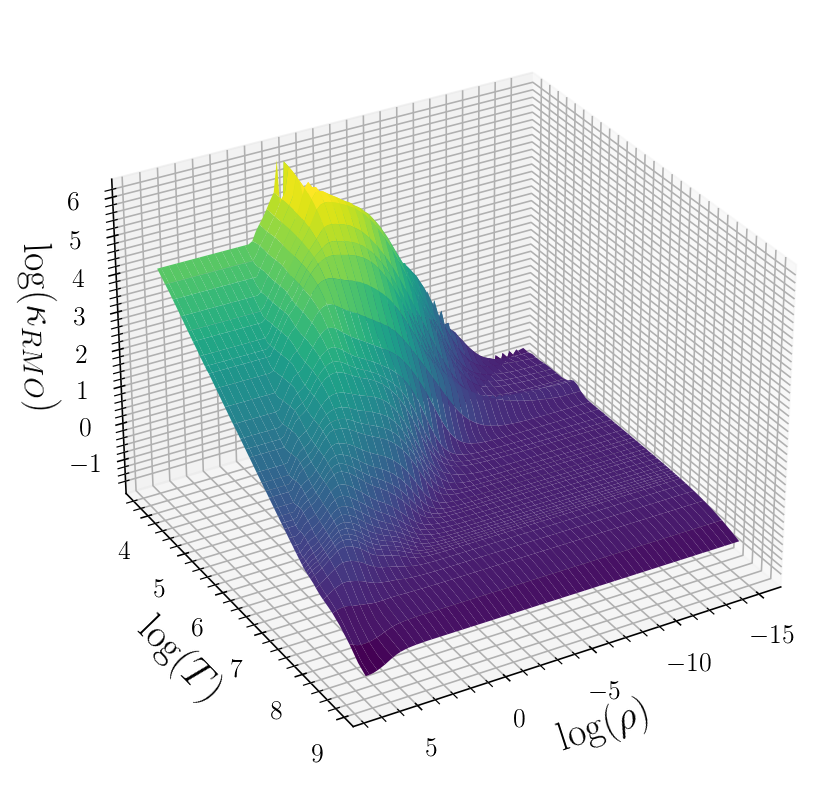

In [9]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(np.log10(rr), TT, RMO.T, cmap='viridis')
ax.view_init(30,60)
ax.set_xlabel(r"$\log(\rho)$", fontsize=20)
ax.set_ylabel(r"$\log(T)$", fontsize=20)
ax.set_zlabel(r"$\log(\kappa_{RMO})$", fontsize=20)

Finally, you may convert mass density and temperature into R and temperature using the conver_rho_2_LogR function. See Boudreaux \& Chaboyer 2022 (in prep.) Appendix A. for more details on how this conversion is preformed.

In [29]:
from pyTOPSScrape.api.convert import convert_rho_2_LogR

In [30]:
help(convert_rho_2_LogR)

Help on function convert_rho_2_LogR in module pyTOPSScrape.api.convert:

convert_rho_2_LogR(rho: numpy.ndarray, LogT: numpy.ndarray, RMO: numpy.ndarray) -> Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]
    Maps a given kappa(rho,logT) parameter space onto a kappa(LogR, LogT) field
    through interpolation. The final field is the field that DSEP needs.
    
    Parameters
    ----------
        rho  : np.ndarray
            mass density array of size n
        LogT : np.ndarray
            LogT array of size m
        RMO : np.ndarray
            Opacity Array of size m x n
    
    
    Returns
    -------
        targetLogR : np.ndarray(shape=19)
            Log R values which dsep requires
        targetLogR : np.ndarray(shape=70)
            Lof T values which dsep requires
        Opacity : np.ndarray(shape=(70, 19))
            Opacity array now interpolated into LogR, LogT space from rho LogT
            space and sampled at the exact LogR and LogT values required.



In [49]:
LogRc, LogTc, RMOc = convert_rho_2_LogR(rho, logT, RMO)

RRc, TTc = np.meshgrid(LogRc, LogTc)

Text(0.5, 0, '$\\log(\\kappa_{RMO})$')

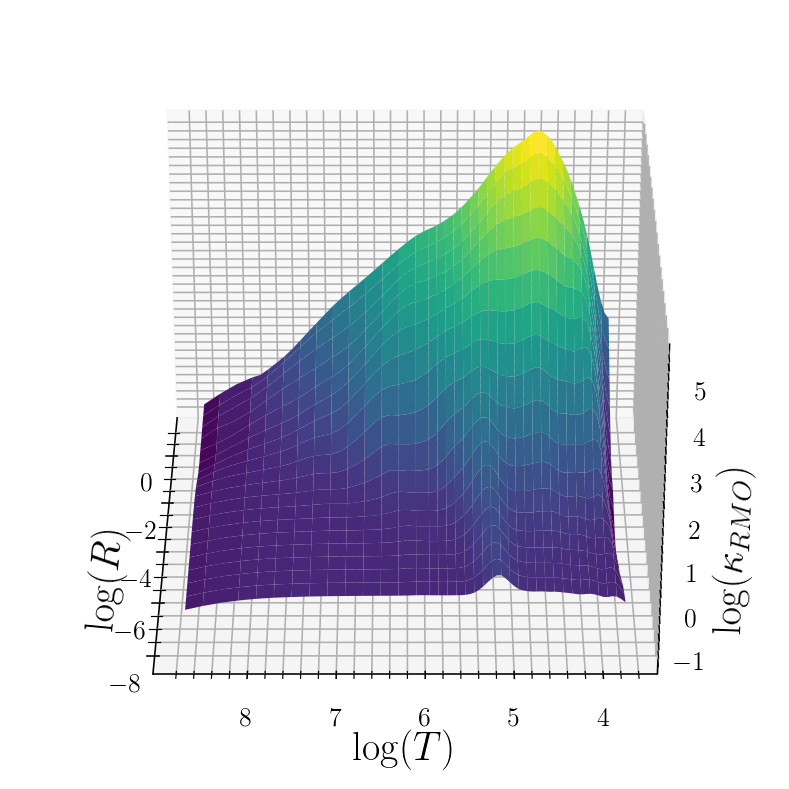

In [55]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(RRc, TTc, RMOc, cmap='viridis')
ax.view_init(30,180)
ax.set_xlabel(r"$\log(R)$", fontsize=20)
ax.set_ylabel(r"$\log(T)$", fontsize=20)
ax.set_zlabel(r"$\log(\kappa_{RMO})$", fontsize=20)

At this stage you can write out RMO and its paramiterization to a file in whatever format your program may expect